# Lab Walkthrough: Mastering Denoising Diffusion Probabilistic Models (DDPM)

Welcome to this in-depth lab on **Denoising Diffusion Probabilistic Models (DDPM)**! DDPMs are a cutting-edge generative modeling technique that create realistic images by learning to reverse a gradual noise-adding process. Unlike GANs, which pit a generator against a discriminator, DDPMs use a probabilistic approach rooted in Markov chains and denoising.

### What is DDPM?
DDPM is based on two processes:
1. **Forward Diffusion**: A Markov process that adds Gaussian noise to an image over $T$ steps until it becomes isotropic Gaussian noise.
2. **Reverse Diffusion**: A learned process that reverses this, transforming noise back into a meaningful image.

#### Mathematical Foundation
- **Forward Process**: Given an image $x_0$ from the data distribution $q(x_0)$, we define a sequence $x_1, x_2, ..., x_T$ where noise is added:
  $$
  q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)
  $$
  Here, $\beta_t$ is a variance schedule that increases over time, controlling the noise level.
- **Key Insight**: After many steps ($T \to \infty$), $x_T \approx \mathcal{N}(0, I)$, pure noise.
- **Reverse Process**: We learn $p_\theta(x_{t-1} | x_t)$, parameterized by a neural network (U-Net), to approximate:
  $$
  p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
  $$

#### Why DDPM?
- **Stable Training**: No adversarial loss, just a clear denoising objective.
- **High Quality**: Matches or exceeds GANs on datasets like CIFAR-10 with proper tuning.
- **Probabilistic**: Models the full data distribution, not just samples.

### Lab Goals
1. Implement the forward process to understand noise addition.
2. Build a U-Net to predict noise in the reverse process.
3. Train and sample from the model using CIFAR-10.

Let’s dive in!

## Step 1: Setting Up the Environment

This cell prepares our tools:
- **TensorFlow**: For building and training the model.
- **CIFAR-10**: 32x32 RGB images (3 channels) with 50,000 training samples.
- **Constants**: `IMG_SIZE=32`, `CHANNELS=3`, `BATCH_SIZE=64` (smaller due to our complex U-Net).

#### Why These Choices?
- CIFAR-10 is small but diverse, perfect for learning DDPM without overwhelming compute.
- Batch size balances memory use and gradient stability.

Run this cell to set up. The random seeds ensure consistent results—crucial for understanding each step’s effect.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import math

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# CIFAR-10 image properties
IMG_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 64  # Reduced batch size for larger model to fit in memory

2025-02-20 18:32:57.092428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740094377.112907  243587 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740094377.119265  243587 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 18:32:57.139796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 2: Loading and Preprocessing CIFAR-10

Here, we load CIFAR-10 and preprocess it:
- **Normalization**: Pixels go from `[0, 255]` to `[0, 1]` via $x \leftarrow x / 255$.
- **Batching**: Groups images into sets of 64 for efficient training.

#### Why Normalize?
Neural networks converge faster with inputs in a small range (e.g., [0, 1]), as it avoids large gradients.

Run this cell and inspect the sample image. Notice its 32x32 resolution and RGB colors—this is $x_0$ in our forward process, the starting point before noise corrupts it!

I0000 00:00:1740094405.733490  243587 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0
2025-02-20 18:33:26.057250: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-20 18:33:26.067768: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


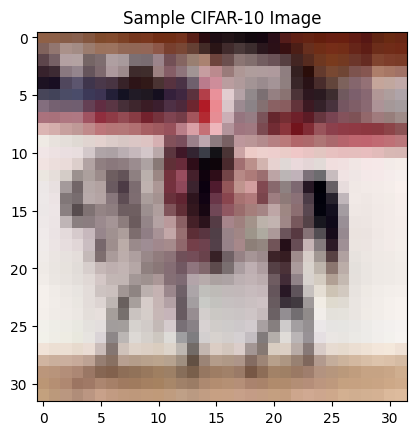

In [2]:
# Load CIFAR-10 dataset
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Load dataset
(train_ds, _), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Visualize a sample
sample = next(iter(train_ds))[0]
plt.imshow(sample[0])
plt.title("Sample CIFAR-10 Image")
plt.show()

## Step 3: Defining the Noise Schedule

The **noise schedule** dictates how noise grows over $T = 1000$ steps. We use a **linear schedule**:
- $\beta_t$: Increases from 0.0001 to 0.02, controlling noise variance.
- $\alpha_t = 1 - \beta_t$: Proportion of signal retained at step $t$.
- $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$: Cumulative signal retention.

#### Forward Process Formula
For any $t$, we can jump directly from $x_0$ to $x_t$ using:
$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$
- $\sqrt{\bar{\alpha}_t} x_0$: Scaled original image.
- $\sqrt{1 - \bar{\alpha}_t} \epsilon$: Scaled noise.

#### Why This Schedule?
- Small $\beta_t$ early on preserves structure; larger $\beta_t$ later ensures $x_T \approx \mathcal{N}(0, I)$.
- Precomputing terms like $\sqrt{\bar{\alpha}_t}$ speeds up training.

Run this cell to define these. We’ll use them to add noise and later reverse it.

In [3]:
# Define the noise schedule (linear beta schedule)
def get_beta_schedule(num_timesteps, beta_start=0.0001, beta_end=0.02):
    betas = tf.linspace(beta_start, beta_end, num_timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = tf.math.cumprod(alphas, axis=0)
    return betas, alphas, alphas_cumprod

NUM_TIMESTEPS = 1000
betas, alphas, alphas_cumprod = get_beta_schedule(NUM_TIMESTEPS)

# Precompute useful terms
sqrt_alphas_cumprod = tf.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.sqrt(1.0 - alphas_cumprod)
one_over_sqrt_alphas = 1.0 / tf.sqrt(alphas)

## Step 4: Forward Diffusion – Adding Noise

The **forward diffusion process** turns $x_0$ into $x_t$ by adding noise over $t$ steps. We implement the direct form:
$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
$$
- $\epsilon$: Random noise from $\mathcal{N}(0, I)$.
- $\bar{\alpha}_t$: From our schedule, determining signal vs. noise balance.

#### Why This Works
- This is derived from the Markov chain $q(x_t | x_{t-1})$ using reparameterization (see DDPM paper).
- At $t = 0$, $x_t = x_0$ (no noise); at $t = 999$, $x_t \approx \epsilon$ (mostly noise).

#### In This Cell
- `forward_diffusion()`: Applies the formula for given timesteps.
- We visualize 4 images at $t = [0, 250, 500, 999]$.

Run this cell. Observe how the image degrades. At $t = 999$, it’s nearly pure noise—this is what our U-Net will learn to undo!

2025-02-20 18:33:27.260608: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


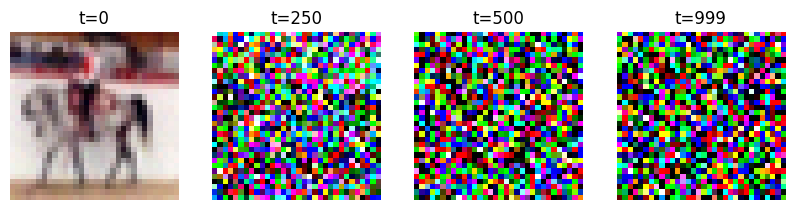

In [4]:
# Forward diffusion process: Add noise to the image
def forward_diffusion(x_0, t, noise=None):
    if noise is None:
        noise = tf.random.normal(shape=tf.shape(x_0))
    sqrt_alpha_t = tf.gather(sqrt_alphas_cumprod, t)
    sqrt_one_minus_alpha_t = tf.gather(sqrt_one_minus_alphas_cumprod, t)
    x_t = sqrt_alpha_t[:, None, None, None] * x_0 + sqrt_one_minus_alpha_t[:, None, None, None] * noise
    return x_t, noise

# Test forward diffusion
sample_images = next(iter(train_ds))[0][:4]  # Take 4 images
t = tf.constant([0, 250, 500, 999])  # Different timesteps
x_t, noise = forward_diffusion(sample_images, t)

# Visualize
plt.figure(figsize=(10, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(tf.clip_by_value(x_t[i], 0, 1))
    plt.title(f"t={t[i]}")
    plt.axis('off')
plt.show()

## Step 5: Building the U-Net Model

The **U-Net** predicts the noise $\epsilon$ added at each step, i.e., $\epsilon_\theta(x_t, t)$. Our enhanced version includes:
- **Encoder**: Downsamples from 32x32 to 2x2, extracting features.
- **Decoder**: Upsamples back to 32x32, reconstructing the image.
- **Skip Connections**: Preserve spatial details across scales.
- **Residual Blocks**: Two convolutions with GroupNormalization and Swish, plus time conditioning.
- **Time Embedding**: Sinusoidal encoding of $t$, inspired by Transformers:
  $$
  \text{emb}(t)_i = \begin{cases} 
  \sin(t / 10000^{i/d}) & \text{if } i \text{ is even} \\
  \cos(t / 10000^{(i-1)/d}) & \text{if } i \text{ is odd}
  \end{cases}
  $$
  where $d = 128$ is the embedding dimension.

#### Why This Design?
- **Depth (64 → 1024)**: Captures complex patterns in CIFAR-10.
- **Residuals**: Prevent vanishing gradients, crucial for deep networks.
- **Time Conditioning**: Tells the U-Net “when” it is, adjusting its prediction per $t$.

Run this cell and check the summary. Notice the millions of parameters—this power enables high-quality generation!

In [5]:
# Define a more complex U-Net architecture for better results
def build_unet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
    time_input = layers.Input(shape=(), dtype=tf.int32)

    # Sinusoidal time embedding (inspired by Transformer positional encodings)
    def get_timestep_embedding(timesteps, embedding_dim=128):
        half_dim = embedding_dim // 2
        emb = tf.math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

    time_emb = layers.Lambda(lambda t: get_timestep_embedding(t))(time_input)
    time_emb = layers.Dense(512, activation='swish')(time_emb)
    time_emb = layers.Dense(512, activation='swish')(time_emb)

    def residual_block(x, filters, t_emb):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.GroupNormalization(groups=32)(x)
        x = layers.Activation('swish')(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.GroupNormalization(groups=32)(x)
        # Add time embedding
        t_dense = layers.Dense(filters, activation='swish')(t_emb)
        t_dense = layers.Reshape((1, 1, filters))(t_dense)
        x = layers.Add()([x, t_dense])
        return layers.Activation('swish')(x)

    # Encoder
    skips = []
    x = layers.Conv2D(64, 3, padding='same', activation='swish')(inputs)
    x = residual_block(x, 64, time_emb)
    skips.append(x)
    x = layers.MaxPooling2D()(x)  # 16x16

    x = residual_block(x, 128, time_emb)
    skips.append(x)
    x = layers.MaxPooling2D()(x)  # 8x8

    x = residual_block(x, 256, time_emb)
    skips.append(x)
    x = layers.MaxPooling2D()(x)  # 4x4

    x = residual_block(x, 512, time_emb)
    skips.append(x)
    x = layers.MaxPooling2D()(x)  # 2x2

    # Bottleneck
    x = residual_block(x, 1024, time_emb)
    x = residual_block(x, 1024, time_emb)

    # Decoder
    x = layers.UpSampling2D()(x)  # 4x4
    x = layers.Concatenate()([x, skips.pop()])
    x = residual_block(x, 512, time_emb)

    x = layers.UpSampling2D()(x)  # 8x8
    x = layers.Concatenate()([x, skips.pop()])
    x = residual_block(x, 256, time_emb)

    x = layers.UpSampling2D()(x)  # 16x16
    x = layers.Concatenate()([x, skips.pop()])
    x = residual_block(x, 128, time_emb)

    x = layers.UpSampling2D()(x)  # 32x32
    x = layers.Concatenate()([x, skips.pop()])
    x = residual_block(x, 64, time_emb)

    # Output
    x = layers.Conv2D(CHANNELS, 3, padding='same')(x)  # Predict noise

    return models.Model([inputs, time_input], x)

unet = build_unet()
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     66,048 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ group_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     32,832 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ group_normalizat… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_3[0][0]    │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 52,674,115 (200.94 MB)

 Trainable params: 52,674,115 (200.94 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Training the U-Net

Training DDPM simplifies the reverse process likelihood into a denoising objective. The reverse step is:
$$
p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \beta_t I)
$$
- $\mu_\theta(x_t, t)$: Mean predicted by the U-Net, derived as:
  $$
  \mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)
  $$
- We train $\epsilon_\theta(x_t, t)$ to match the true noise $\epsilon$.

#### Loss Function
The simplified variational bound yields:
$$
L = \mathbb{E}_{t, x_0, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|_2^2 \right]
$$
- Sample $t$ randomly, compute $x_t$, predict $\epsilon$, and minimize MSE.

#### In This Cell
- 100 epochs, Adam optimizer with $\eta = 2 \times 10^{-4}$.
- Loss decreases as $\epsilon_\theta$ improves.

Run this cell (it’s slow—hours on a GPU). Watch the loss drop, indicating the U-Net is learning to denoise!

In [6]:
# Define loss function and training step
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)  # Slightly higher learning rate for faster convergence

@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]
    t = tf.random.uniform([batch_size], 0, NUM_TIMESTEPS, dtype=tf.int32)
    x_t, noise = forward_diffusion(images, t)
    
    with tf.GradientTape() as tape:
        predicted_noise = unet([x_t, t], training=True)
        loss = tf.reduce_mean(tf.square(noise - predicted_noise))  # MSE loss
    
    gradients = tape.gradient(loss, unet.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet.trainable_variables))
    return loss

# Training loop
EPOCHS = 100  # Increased epochs for better training
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    total_loss = 0
    num_batches = 0
    for images, _ in train_ds:
        loss = train_step(images)
        total_loss += loss
        num_batches += 1
    print(f"Average Loss: {total_loss / num_batches:.4f}")

Epoch 1/100


I0000 00:00:1740094424.621465  243918 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-20 18:37:09.693468: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0320
Epoch 3/100
Average Loss: 0.0291
Epoch 4/100


2025-02-20 18:41:08.360786: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0266
Epoch 5/100
Average Loss: 0.0254
Epoch 6/100
Average Loss: 0.0241
Epoch 7/100
Average Loss: 0.0235
Epoch 8/100


2025-02-20 18:48:20.523063: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0227
Epoch 9/100
Average Loss: 0.0228
Epoch 10/100
Average Loss: 0.0222
Epoch 11/100
Average Loss: 0.0214
Epoch 12/100
Average Loss: 0.0213
Epoch 13/100
Average Loss: 0.0214
Epoch 14/100
Average Loss: 0.0213
Epoch 15/100
Average Loss: 0.0211
Epoch 16/100


2025-02-20 19:01:59.538326: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0208
Epoch 17/100
Average Loss: 0.0206
Epoch 18/100
Average Loss: 0.0206
Epoch 19/100
Average Loss: 0.0203
Epoch 20/100
Average Loss: 0.0198
Epoch 21/100
Average Loss: 0.0208
Epoch 22/100
Average Loss: 0.0200
Epoch 23/100
Average Loss: 0.0199
Epoch 24/100
Average Loss: 0.0199
Epoch 25/100
Average Loss: 0.0200
Epoch 26/100
Average Loss: 0.0196
Epoch 27/100
Average Loss: 0.0202
Epoch 28/100
Average Loss: 0.0198
Epoch 29/100
Average Loss: 0.0198
Epoch 30/100
Average Loss: 0.0196
Epoch 31/100
Average Loss: 0.0199
Epoch 32/100


2025-02-20 19:28:32.322018: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0198
Epoch 33/100
Average Loss: 0.0192
Epoch 34/100
Average Loss: 0.0192
Epoch 35/100
Average Loss: 0.0193
Epoch 36/100
Average Loss: 0.0194
Epoch 37/100
Average Loss: 0.0196
Epoch 38/100
Average Loss: 0.0188
Epoch 39/100
Average Loss: 0.0193
Epoch 40/100
Average Loss: 0.0188
Epoch 41/100
Average Loss: 0.0198
Epoch 42/100
Average Loss: 0.0194
Epoch 43/100
Average Loss: 0.0190
Epoch 44/100
Average Loss: 0.0189
Epoch 45/100
Average Loss: 0.0189
Epoch 46/100
Average Loss: 0.0189
Epoch 47/100
Average Loss: 0.0187
Epoch 48/100
Average Loss: 0.0187
Epoch 49/100
Average Loss: 0.0188
Epoch 50/100
Average Loss: 0.0186
Epoch 51/100
Average Loss: 0.0187
Epoch 52/100
Average Loss: 0.0189
Epoch 54/100
Average Loss: 0.0185
Epoch 55/100
Average Loss: 0.0190
Epoch 56/100
Average Loss: 0.0187
Epoch 59/100
Average Loss: 0.0184
Epoch 60/100
Average Loss: 0.0183
Epoch 61/100
Average Loss: 0.0186
Epoch 62/100
Average Loss: 0.0185
Epoch 63/100


2025-02-20 20:21:37.781205: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0186
Epoch 65/100
Average Loss: 0.0186
Epoch 66/100
Average Loss: 0.0184
Epoch 67/100
Average Loss: 0.0187
Epoch 68/100
Average Loss: 0.0181
Epoch 69/100
Average Loss: 0.0180
Epoch 70/100
Average Loss: 0.0183
Epoch 71/100
Average Loss: 0.0184
Epoch 72/100
Average Loss: 0.0184
Epoch 73/100
Average Loss: 0.0183
Epoch 74/100
Average Loss: 0.0185
Epoch 75/100
Average Loss: 0.0187
Epoch 76/100
Average Loss: 0.0181
Epoch 77/100
Average Loss: 0.0182
Epoch 78/100
Average Loss: 0.0183
Epoch 79/100
Average Loss: 0.0178
Epoch 80/100
Average Loss: 0.0184
Epoch 81/100
Average Loss: 0.0180
Epoch 82/100
Average Loss: 0.0186
Epoch 83/100
Average Loss: 0.0184
Epoch 84/100
Average Loss: 0.0182
Epoch 85/100
Average Loss: 0.0182
Epoch 86/100
Average Loss: 0.0182
Epoch 87/100
Average Loss: 0.0182
Epoch 88/100
Average Loss: 0.0181
Epoch 89/100
Average Loss: 0.0180
Epoch 92/100
Average Loss: 0.0184
Epoch 93/100
Average Loss: 0.0180
Epoch 94/100
Average Loss: 0.0183
Epoch 95/100
Average Loss: 

## Step 7: Reverse Diffusion – Generating Images

The **reverse diffusion process** samples $x_{T-1}, ..., x_0$ from noise:
$$
x_{t-1} = \mu_\theta(x_t, t) + \sqrt{\beta_t} z, \quad z \sim \mathcal{N}(0, I)
$$
- For $t > 0$, add noise; for $t = 0$, stop (no noise).

#### Sampling Steps
1. Start with $x_T \sim \mathcal{N}(0, I)$.
2. For $t = 999$ to 0, compute $x_{t-1}$ using the U-Net’s $\epsilon_\theta$.

#### In This Cell
- `reverse_diffusion()`: Implements the formula.
- `sample()`: Runs 1000 steps to generate 4 images.

Run this cell post-training. The results should resemble CIFAR-10 classes—proof the model learned the data distribution!

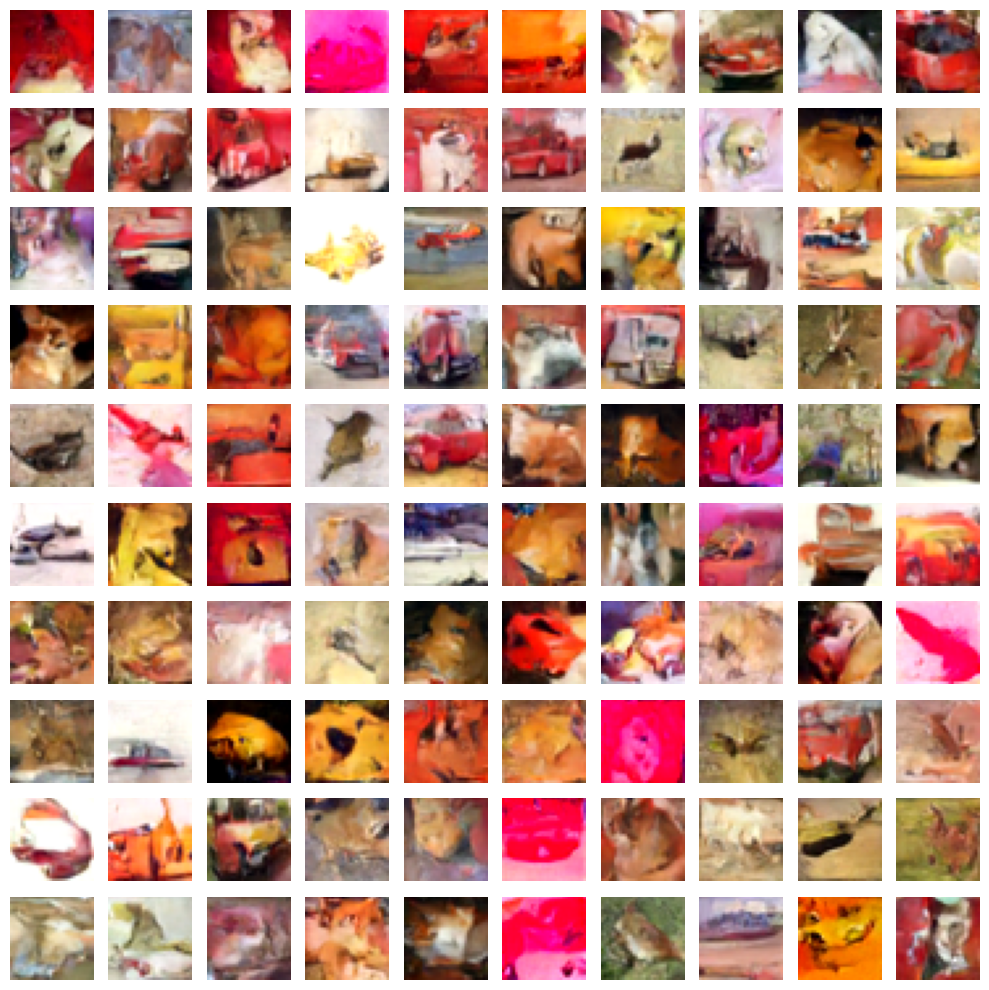

In [12]:
# Reverse diffusion process for sampling
def reverse_diffusion(x_t, t):
    predicted_noise = unet([x_t, t], training=False)
    one_over_sqrt_alpha_t = tf.gather(one_over_sqrt_alphas, t)
    beta_t = tf.gather(betas, t)
    sqrt_one_minus_alpha_cumprod_t = tf.gather(sqrt_one_minus_alphas_cumprod, t)
    
    mean = one_over_sqrt_alpha_t[:, None, None, None] * (
        x_t - (beta_t[:, None, None, None] * predicted_noise) / sqrt_one_minus_alpha_cumprod_t[:, None, None, None]
    )
    if tf.reduce_all(t > 0):
        noise = tf.random.normal(shape=tf.shape(x_t))
        variance = tf.sqrt(beta_t[:, None, None, None]) * noise
    else:
        variance = 0
    return mean + variance

# Sampling function
def sample(num_samples=4):
    x_t = tf.random.normal([num_samples, IMG_SIZE, IMG_SIZE, CHANNELS])
    for t in range(NUM_TIMESTEPS-1, -1, -1):
        t_tensor = tf.fill([num_samples], t)
        x_t = reverse_diffusion(x_t, t_tensor)
    return tf.clip_by_value(x_t, 0, 1)

# Generate samples
generated_images = sample(100)  # Generate 100 images
plt.figure(figsize=(10, 10))  # Set figure size

for i in range(100):
    plt.subplot(10, 10, i + 1)  # Arrange in 10 rows × 10 cols
    plt.imshow(generated_images[i])
    plt.axis('off')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


## Conclusion: Mastering DDPM

You’ve built a DDPM from scratch! Key takeaways:
- **Forward Process**: $q(x_t | x_{t-1})$ adds noise until $x_T \approx \mathcal{N}(0, I)$.
- **Reverse Process**: $p_\theta(x_{t-1} | x_t)$ denoises using a U-Net trained on $\epsilon$.
- **Training**: Minimizes $\| \epsilon - \epsilon_\theta \|^2$, a simple yet effective loss.

### Deep Reflection
1. **Math Exploration**: Derive why $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$ holds from $q(x_t | x_{t-1})$.
2. **Schedule Impact**: Why linear $\beta_t$? Test a cosine schedule—does it improve quality?
3. **U-Net Role**: How do residuals and time embeddings enhance performance?
4. **Generated Images**: Analyze strengths (e.g., color) and weaknesses (e.g., sharpness).

Experiment further—try $T = 500$ or tweak the U-Net. You now understand DDPM’s core principles and implementation!